In [1]:
import os
import django


def parse_dot_env(path):
    values = {}
    with open(path) as f:
        lines = f.readlines()
        for line in lines:
            if line and "=" in line:
                s = line.split("=")
                values[s[0].strip()] = s[1].strip()
    return values


def set_env(env_dict):
    for key in env_dict:
        os.environ.setdefault(key, env_dict[key])


def init(env_path):
    set_env(parse_dot_env(env_path))  # first load the .env
    os.environ["DJANGO_SETTINGS_MODULE"] = "backend.backend.settings"
    django.setup()  # takes a few moments

print("Working directory:", os.getcwd())
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
os.chdir("/home")
print("Working directory is now:", os.getcwd())
env_path = os.path.abspath(".env/.env.dev")
print("Importing", env_path)
init(env_path)

Working directory: /home/backend/analysis
Working directory is now: /home
Importing /home/.env/.env.dev
DEBUG True
MEDIA_ROOT /home/backend/run/media
STATIC_ROOT /home/backend/run/static
STATICFILES_DIRS /home/backend/static
ALLOWED_HOSTS *
CORS_ORIGIN_WHITELIST http://localtest.me
CSRF_TRUSTED_ORIGINS localtest.me
Control Server ready


In [2]:
"""
Configuration, please adjust if needed.
"""
from control_server.models import Experiment, Messenger
from datetime import datetime, timedelta

import pytz
from django.db.models import Q

# everything after this date counts
earliest_date = datetime(year=2024, month=2, day=26, tzinfo=pytz.timezone('Europe/Berlin'))

# all filtered_experiments receive +X days after being conducted
# experiment_duration = timedelta(days=90)
# None means no limit
experiment_duration = None

# (Optional) Add experiment ID to ignore it, e.g., for tests
experiment_blocklist = list([
    # ...
])

known_ips = {
    "senders": [
        r"127\.0\.0\.1",  # example
        # ...
    ],
    "receivers": [
        r"127\.0\.0\.2",  # example
        # ...
    ]
}

# (Optional) Map messenger name in the framework to a verbose name for plotting
messenger_name_mapping = {
    'org.thoughtcrime.securesms': 'Signal',  # map signal package name
    "signal": "Signal",
}

def humanize_messenger_name(messenger_name):
    return messenger_name_mapping.get(messenger_name.lower(), messenger_name)

In [3]:
"""
No need to change.
"""
# Q filters to exclude client-side requests
# Create Q objects for each regular expression in the lists
_q_ip_sender_filter = [Q(ip_address__regex=regex) for regex in known_ips["senders"]]
_q_ip_receiver_filter = [Q(ip_address__regex=regex) for regex in known_ips["receivers"]]

# Combine the Q objects with OR for each list
_q_combined_sender_filter = Q()
for q_object in _q_ip_sender_filter:
    _q_combined_sender_filter |= q_object

_q_combined_receiver_filter = Q()
for q_object in _q_ip_receiver_filter:
    _q_combined_receiver_filter |= q_object

# Combine the Q objects with AND for the final query
# usage: logs.exclude(known_ip_q_filter)  # to exclude all client-side requests
known_ip_q_filter = _q_combined_sender_filter | _q_combined_receiver_filter

def matches_any_pattern(patterns, string):
    return any(re.search(pattern, string) for pattern in patterns)

def read_json(file):
    with open(file, "r") as f:
        return json.load(f)

def write_json_to_file(obj, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, "w") as outfile:
        json.dump(obj, outfile, indent=4, default=str)
    print("Wrote to", filename)
    
def write_to_file(obj, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, "w") as outfile:
        outfile.write(obj)
    print("Wrote to", filename)
    
def analyze_messengers(_messengers, verbose=False):
    full_results = defaultdict(list)
    results = defaultdict(list)
    for _messenger in _messengers:
        # these are the experiments in-scope that belong to this messenger
        _experiments_in_scope = filtered_hp_experiments.filter(messenger__id=_messenger.id)

        for _experiment in _experiments_in_scope:
            experiment_analysis = _experiment.analyze(experiment_duration=experiment_duration)

            _ips = experiment_analysis["evaluation"]["ips"]
            is_sender_ip = False
            is_receiver_ip = False
            for _ip in _ips:
                if matches_any_pattern(known_ips["senders"], _ip):
                    is_sender_ip = True
                if matches_any_pattern(known_ips["receivers"], _ip):
                    is_receiver_ip = True

            experiment_analysis["evaluation"]["is_sender_ip"] = is_sender_ip
            experiment_analysis["evaluation"]["is_receiver_ip"] = is_receiver_ip

            if verbose:
                print(json.dumps(experiment_analysis, indent=4))

            results[_messenger.name].append(experiment_analysis["evaluation"])
            full_results[_messenger.name].append(experiment_analysis)

    return {"results": results, "full_results": full_results}



In [4]:
"""
Import data from  models according to configuration
"""
# Honeypage AND Honeymail Experiments in scope
filtered_experiments = Experiment.objects.filter(
    created_at__gte=earliest_date  # start here
).exclude(
    id__in=experiment_blocklist  # all filtered_experiments from the blocklist are ignored
).exclude(
    name__istartswith="test"  # Experiments with a name starting with "test" are ignored
).exclude(
    messenger__name="Test Messenger"
)

# only Honeypage experiments in scope
filtered_hp_experiments = filtered_experiments.filter(honeypage__isnull=False)
print(filtered_hp_experiments.count(), "Honeypage Experiments after", earliest_date, "are in scope.")
print(Experiment.objects.count(), "Experiments total")

filtered_messengers = [
    x for x in Messenger.objects.exclude(name="Test Messenger")  # filters
    if x.experiments.count() >= 1  # include condition
]

3 Honeypage Experiments after 2024-02-26 00:00:00+00:53 are in scope.
3 Experiments total


In [5]:
def save_timings(full_results_with_access, out_path):
    timings = {}
    types = ["meta_honeypage", "honeypage", "suspicious_honeypage"]

    for messenger_name, full_results_list in full_results_with_access.items():
        timings[messenger_name] = defaultdict(list)
        found = [0, 0, 0]

        for _res_dict in full_results_list:
            for i in range(len(types)):
                exp_type = types[i]
                if _res_dict["evaluation"]["experiment_type"] == exp_type:
                    found[i] += 1
                    if found[i] > 1:
                        print("Attention, unexpected amount of experiment types", exp_type, "found for", messenger_name)
                    times = _res_dict["evaluation"]["ssr_seconds_since_experiment"]
                    timings[messenger_name][exp_type] = [int(time) for time in times]

    write_json_to_file(timings, out_path)

def filter_full_messenger_results(_full_results_dict):
    """
    Splits results into with_access and without_access.
    @param _full_results_dict:
    @return:
    """
    _with_access = defaultdict(list)
    _without_access = defaultdict(list)
    for messenger_name, results in _full_results_dict.items():
        for result in results:
            if result["evaluation"]["honeypage_accessed"]:
                _with_access[messenger_name].append(result)
            else:
                _without_access[messenger_name].append(result)
    return _with_access, _without_access

def create_tables(_eval_results):
    for category_data in _eval_results:
        _name = category_data["name"]
        _table_name = category_data["table_name"]
        _evaluation = category_data["evaluation"]
        _results = _evaluation["results"]

        _full_results = _evaluation["full_results"]
        _full_results_with_access, _full_results_without_access = filter_full_messenger_results(_full_results)
        
        out_path = os.path.join(os.getcwd(), "out", "timings", _name + "-ssr-timing.json")
        save_timings(_full_results_with_access, out_path)

In [6]:
"""
Plotting helpers
"""

from matplotlib import pyplot as plt
import seaborn as sns

def bucketize(value, _buckets):
    for label, duration in _buckets.items():
        if value <= duration:
            return label
    return list(_buckets.keys())[-1]  # final bucket


def preprocess_data(_data, _buckets):
    result = {}

    for messenger, metrics in _data.items():
        messenger_result = {}
        for category, values in metrics.items():
            category_result = {}
            for value in values:
                bucket_label = bucketize(value, _buckets)
                category_result[bucket_label] = category_result.get(bucket_label, 0) + 1
            messenger_result[category] = category_result
        messenger_name = humanize_messenger_name(messenger)
        result[messenger_name] = messenger_result

    return result

def filter_data(results, _buckets, min_bucket_id):
    filtered_results = {}

    for app, honeys in results.items():
        include_app = False
        for idx in range(min_bucket_id, len(_buckets.keys()) - 1):
            bucket_key_to_check = list(_buckets.keys())[idx]
            for honey, metrics in honeys.items():
                if bucket_key_to_check in metrics.keys() and metrics[bucket_key_to_check] > 0:
                    include_app = True
                    break
        if include_app:
            filtered_results[app] = honeys
    
    return filtered_results

# this function is used to both get the offset of the column, as well as the name for each honey type
# if there are more/other honey types simply expand the if-else
# this requires some experimentation based on the amount of possible elements to figure out the best offsets
def get_honey_offset(honey_type):
    if honey_type == "meta_honeypage":
        return -0.24, "regular honeypage"
    if honey_type == "honeypage":
        return 0.0, "meta honeypage"
    elif honey_type == "suspicious_honeypage":
        return 0.24, "suspicious honeypage"
    else:
        raise Exception("unknown honeypage type " + honey_type)


# function to create the scatter plot based on the expected json format/map structure
# @param json - the data set in the expected structure
# @param buckets - the names of the buckets contained in the data strucured, ordered from smallest to largest
# @param fileName - the name of the file to write the results into
def create_scatter_plot_req(_json, _buckets, file_name="timeaccess.pdf"):
    apps = list(_json.keys())
    plot_x = list()
    plot_y = list()
    size = list()
    marker = list()    
    
    # those are the markers to be used, they have to match in count the amount of different honey types we have. Markers are listed here https://seaborn.pydata.org/tutorial/properties.html
    markers = ["D", "o", "X"]  # markers correspond to honey types order
    honey_types_order = ["meta_honeypage", "honeypage", "suspicious_honeypage"]
    
    for app, honeys in _json.items():
        app_index = apps.index(app)
        sorted_honeys = dict(sorted(honeys.items(), key=lambda item: honey_types_order.index(item[0])))
        for honey_type, requests in sorted_honeys.items():
            honey_offset, honey_marker = get_honey_offset(honey_type)  # here we get the offset of center column for each honey type
            for bucket_name, count in requests.items():
                column = list(_buckets.keys()).index(bucket_name)
                size.append(count)  # here we define the size of the marker based on the request count
                plot_y.append(app_index)  # here we plot the row for the app
                plot_x.append(column + honey_offset)  # here we add the colum for the marker as well as the offset of the center of the column to plot multiple markers for different honey types
                marker.append(honey_marker)
    # this is the data package for seaborn to plot against
    _data = {
        "x": plot_x,
        "y": plot_y,
        r"\textbf{Requests}": size,  # by renaming this value and adapting the scatterplot call you can affect the legend 
        r"\textbf{Honeypage type}": marker  # by renaming this value and adapting the scatterplot call you can affect the legend
    }
    plt.rcParams['lines.markersize'] = 7
    
    fig, ax = plt.subplots(
        figsize=[
            1 * default_figsize_x,
            1 * default_figsize_y
        ])  # here we can adjust the figure size by multiplying the default size values set in the notebook preamble at the top
    sns.scatterplot(x="x", y="y",
                    # hue="Platform", we do not have different hues thus commented out
                    # hue_order=['Android', 'iOS'], we do not have different hues thus commented out
                    style=r"\textbf{Honeypage type}",
                    ax=ax,
                    size=r"\textbf{Requests}",
                    data=_data,
                    legend=True,
                    markers=markers, edgecolor="none"
    )
    
    ax.set_yticks(range(0, len(apps)))  # here we define the y ticks we use for our plot, i.e., the different apps we tested
    ax.set_yticklabels(apps)  # here we define the y labels to use for our y ticks defined above 

    ax.set_xticks(range(0, len(buckets)))  # here we define the x ticks, i.e., the amount of delay buckets
    ax.set_xticklabels(buckets)  # here we define the y labels to use for our x ticks defined above
    
    ax.set_xlabel(r'\textbf{Time between message and SSR}')
    ax.set_ylabel(r'\textbf{Messengers}')

    sns.move_legend(ax, loc='upper right', ncols=1)
    
    plt.tight_layout()
    fig.savefig(file_name, bbox_inches="tight", pad_inches=0)

In [7]:
"""
Calculate and save data
"""
from collections import defaultdict
import re
import json

eval_results = [
    {
        "table_name": "All Messengers",
        "name": "all-results",
        "evaluation": analyze_messengers(filtered_messengers, verbose=False)
    },
    # other categories of messengers can be added
]

create_tables(eval_results)

Wrote to /home/out/timings/all-results-ssr-timing.json


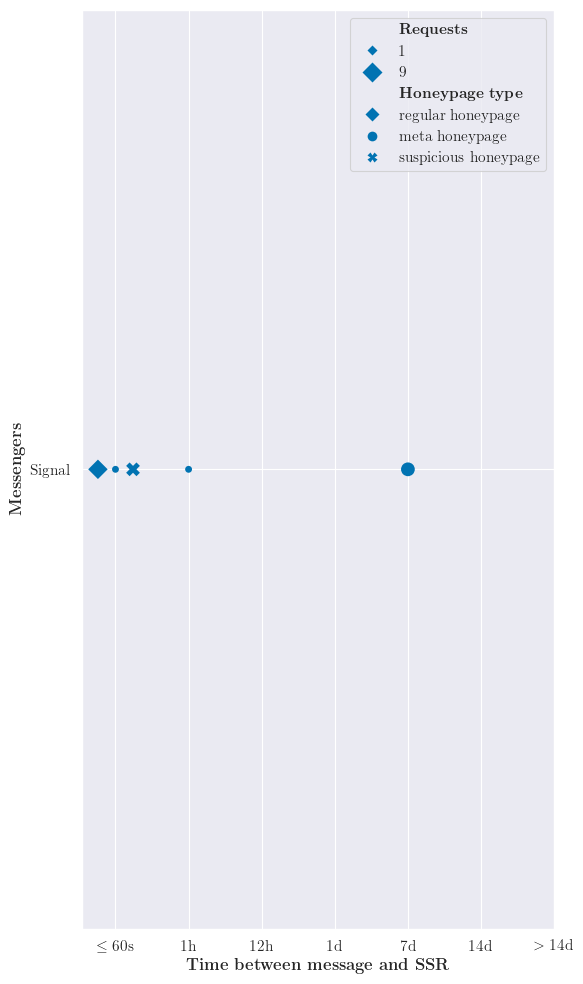

In [8]:
"""
Plot data
"""

sns.reset_defaults()
sns.set_theme(context="paper", font_scale=1.25, palette="colorblind")

hour = 60 * 60
day = 24 * hour
week = 7 * day

# 1min, >1h, >12h, >24h, >7d, > 14d, >21d, >28d
buckets = {
    #"1s": 1,
    #"10s": 10,
    r"$\leq60$s": 60,
    "$1$h": hour,
    "$12$h": 12 * hour,
    "$1$d": day,
    "$7$d": 7 * day,
    "$14$d": 14 * day,
    "$>14$d": 14 * day + 1,
}

data = {}
data |= read_json("out/timings/all-results-ssr-timing.json")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

default_figsize_x, default_figsize_y = 6, 10

out_file = os.path.join("out", "timings", "timeaccess.png")
create_scatter_plot_req(filter_data(preprocess_data(data, buckets), buckets, 0), buckets, out_file)  